## Finetune Image to Text model สำหรับภาษาไทย

การทำ task ประเภท image captioning หรือการให้ ai บรรยายภาพ ในทางเทคนิคคือการแปลง tensor ภาพ ไปเป็นข้อความ โดยทั่วไปนิยมใช้โมเดล Blip-2 แต่ว่าโมเดลตัวนี้ถูกเทรนมาบนภาษาอังกฤษ การจะให้มันบรรยายไทยได้จำเป็นจะต้องมีการดัดแปลงโมเดล

# set up environment

ขั้นแรกเราต้องทำการเซตอัพ lib ที่จำเป็น เนื่องจากว่าเราจะต้องมีการดัดแปลงไฟล์ใน lib transformers ดังนั้นจะต้อง uninstall lib ตัวนี้ออกไปก่อนแล้วติดตั้งผ่าน git clone แทน

In [ ]:
!pip uninstall transformers -y

Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2


In [ ]:
!git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 238388, done.
remote: Counting objects: 100% (1671/1671), done.
remote: Compressing objects: 100% (640/640), done.
remote: Total 238388 (delta 1189), reused 1333 (delta 932), pack-reused 236717 (from 1)
Receiving objects: 100% (238388/238388), 252.20 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (174122/174122), done.


In [ ]:
%cd transformers

/content/transformers


In [ ]:
#install important libs
!pip install -U -q bitsandbytes
!pip install -q peft
!pip install -U -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.insert(0, '/content/transformers/src')
!pip install -e /content/transformers

Obtaining file:///content/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.47.0.dev0-0.editable-py3-none-any.whl size=17261 sha256=8649419acba7d69b9132486567f1cd5792fdb3f100fc9027f270f6159f2757c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3asxwm2/wheels/7c/35/80/e946b22a081210c6642e607ed65b2a5b9a4d9259695ee2caf5
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.0
    Uninstalling transformers-4.46.0:
      Successfully uninstalled transformers-4.46.0


ใน transformers/src/transformers/models/blip_2 ไฟล์นี้จะมีส่วนที่จะทำให้เกิด bug ตอนที่เราพยายามดัดแปลงเอาโมเดลภาษาไทยมาต่อให้เราแก้ไลน์ที่เขียนว่า.

loss = loss_fct(shift_logits.view(-1, self.config.text_config.vocab_size), shift_labels.view(-1))  

ไปเป็น.

loss = loss_fct(shift_logits.view(-1, shift_logits.shape[2]), shift_labels.view(-1))

In [ ]:
import shutil
import os

# Define source and destination paths
source_file = "/content/modeling_blip_2.py"  # Replace with the actual path to your file
destination_directory = "/content/transformers/src/transformers/models/blip_2"

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Define the destination file path
destination_file = os.path.join(destination_directory, os.path.basename(source_file))

# Move the file
shutil.move(source_file, destination_file)

print(f"File moved to: {destination_file}")

File moved to: /content/transformers/src/transformers/models/blip_2/modeling_blip_2.py


# Load pretrained models

โหลดโมเดล blip-2 หลักมา แล้วก็โหลดตัวโมเดลภาษาไทยมา

In [ ]:
import transformers

# Print the path of the imported transformers module
print(transformers.__file__)

/content/transformers/src/transformers/__init__.py


ในขั้นตอนที่เราโหลดโมเดล Blip-2 อาจจะมีการทำ quantization ลด precision ลงแต่แลกกับโมเดลที่ไม่เป็นภาระต่อทรัพยากรมากนัก

In [ ]:
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Set to load in 8-bit
    bnb_8bit_use_double_quant=True,  # Optional: use double quantization
    bnb_8bit_quant_type="nf4",  # Optional: set quantization type
    bnb_8bit_compute_dtype=torch.bfloat16  # Use bfloat16 for computation
)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", quantization_config=bnb_config, device_map={'':0})

Unused kwargs: ['bnb_8bit_use_double_quant', 'bnb_8bit_quant_type', 'bnb_8bit_compute_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

โมเดล Blip-2 นั้น มีองค์ประกอบหลักอยู่ 3 ส่วนคือ โมเดลภาพ + โมเดลกลาง + โมเดลภาษา ในสองส่วนแรกเราจะใช้จากตัวดั้งเดิมเพราะถือว่าเทรนมาบ้างแล้ว ส่วนฝั่งโมเดลภาษาเราจะทำการเปลี่ยนไปใช้โมเดลอีกตัวที่เทรนมาจากภาษาไทย

In [ ]:
from transformers import GPT2LMHeadModel

pretrained_name = "flax-community/gpt2-base-thai"

th_language_model = GPT2LMHeadModel.from_pretrained(pretrained_name, quantization_config=bnb_config)
model.language_model = th_language_model

`low_cpu_mem_usage` was None, now default to True since model is quantized.


ที่เลเยอร์ model.language_projection เป็นรอยต่อระหว่างสองโมเดล จะมีขนาดที่ไม่สอดคล้องกัน จึงต้องทำการเปลี่ยนเพื่อให้ต่อโมเดลได้แนบสนิทและถูกต้อง

In [ ]:
import bitsandbytes as bnb

# Create a Linear4bit layer with specified in_features and out_features
in_features = 768
out_features = 768
# linear_layer = bnb.nn.Linear4bit(in_features, out_features, bias=True)
linear_layer = bnb.nn.Linear8bitLt(in_features, out_features, bias=True)

# Print the created layer to verify its configuration
print(linear_layer)

print("Original layer:", model.language_projection)

# Replace the original layer with the new layer
model.language_projection = linear_layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.language_projection.to(device)

# Verify the change
print("Updated layer:", model.language_projection)

Linear8bitLt(in_features=768, out_features=768, bias=True)
Original layer: Linear8bitLt(in_features=768, out_features=2560, bias=True)
Updated layer: Linear8bitLt(in_features=768, out_features=768, bias=True)


# Prepare Dataset and Training Scheme

จากนั้นเราจะมีการใช้ lib peft ทำการปรับเลเยอร์บางส่วนให้ finetune แบบ LoRA หรือก็คือเราจะไม่พยายามเทรนทั้งตัวโมเดล แต่จะเทรนแค่บางส่วนเท่านั้น เพื่อจะได้คงความรู้เดิมของโมเดลเดิมเอาไว้ ในกรณีนี้เราจะเทรนแค่โมเดลฝั่งภาษาเท่านั้น

In [ ]:
from peft import LoraConfig, get_peft_model

modules = ["language_projection","c_attn","c_proj"]

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=modules
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 1,646,592 || all params: 1,217,791,488 || trainable%: 0.1352


เตรียม data เราจะใช้แค่ภาพเดียวสำหรับการทำชุดสาธิตนี้ หลัก ๆ คือทดสอบโมเดลว่ามีความสามารถจะ overfit ได้หรือไม่ ถ้าทำได้แสดงว่าโมเดลมีศักยภาพที่จะเรียนรู้

In [ ]:
from datasets import Dataset, Features, Value, Image
import pandas as pd

# Example data
data = [
    {"image": "/content/000000196888.jpg",
     "text": "นกน้อยตัวหนึ่งกำลังจิกกินเศษอาหารที่วางทิ้งไว้บนโต๊ะ"},
]

# Define features for the dataset
features = Features({
    'image': Image(),  # Specify the 'image' column as an Image feature
    'text': Value('string')  # Specify the 'text' column as a string
})

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df, features=features)

# Display the dataset
print(dataset)

Dataset({
    features: ['image', 'text'],
    num_rows: 1
})


โหลดตัว tokenizer ซึ่งจะเป็นส่วนที่ใช้แปลภาษาของ ai (ที่เป็นตัวเลขและ tensor) ให้กลายมาเป็นภาษาคน โดยจะมีการเซตอัพโทเคนพิเศษ เพราะดูเหมือนว่าโมเดลภาษาไทยที่นำมาต่อเหมือนจะไม่ได้เซตอัพมา

In [ ]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_name)

tokenizer.bos_token_id = 0
tokenizer.eos_token_id = 2
tokenizer.pad_token_id = 1
tokenizer.unk_token_id = 3
tokenizer.mask_token_id = 4

special_tokens = {
    "bos_token": tokenizer.bos_token,
    "eos_token": tokenizer.eos_token,
    "pad_token": tokenizer.pad_token,
    "unk_token": tokenizer.unk_token,
    "mask_token": tokenizer.mask_token
}

for token_name, token in special_tokens.items():
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"{token_name}: {token} - {token_id}")

tokenizer_config.json:   0%|          | 0.00/208 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/902k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.25M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

bos_token: <s> - 0
eos_token: </s> - 2
pad_token: <pad> - 1
unk_token: <unk> - 3
mask_token: <mask> - 4


สร้าง torch dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt",
                truncation=True, # Add truncation to prevent exceeding max length
                max_length=512,
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, collate_fn=collate_fn)

# Training Session and Inference

เราจะทำการทดสอบโมเดลก่อนที่ทำการ finetune

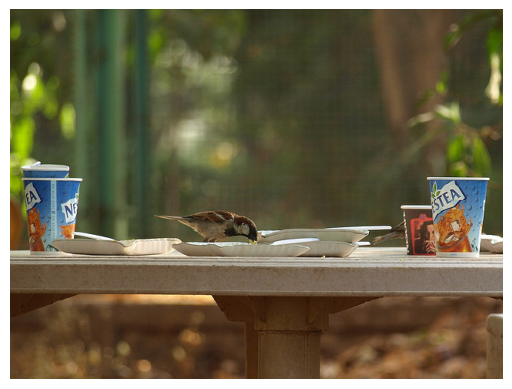

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>อกไก่สีดำสีขาวสีดำสีขาวสีดำสีขาวสี


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/content/000000196888.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off') # Hide axis
plt.show()

image = Image.open(image_path)
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = tokenizer.batch_decode(generated_ids, skip_special_tokens=False)[0]
print(generated_caption)

จะเห็นว่าผลลัพธ์ก่อนเทรน โมเดลพ่นข้อความมั่ว ๆ ออกมา เราจะเข้าสู่การเทรนซึ่ง hyperparameter ต่าง ๆ อย่างจำนวน epoch คือเน้นเยอะ ๆ เอาไว้เพื่อจะ overfit

In [ ]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast

device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=250, gamma=0.8)
model.train()

# Initialize GradScaler for mixed precision
scaler = GradScaler()

for epoch in range(1000):
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        # Use autocast to enable mixed precision
        with autocast():
            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)
            loss = outputs.loss

        if (epoch + 1) % 20 == 0:
            print("Epoch:", epoch+1, "Loss:", loss.item(), f"LR: {scheduler.get_last_lr()[0]:.6f}")
            inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
            pixel_values = inputs.pixel_values
            generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
            generated_caption = tokenizer.batch_decode(generated_ids, skip_special_tokens=False)[0]
            print(generated_caption)

        # Scale the loss and call backward() to create scaled gradients
        scaler.scale(loss).backward()

        # Update the optimizer
        scaler.step(optimizer)
        scaler.update()  # Update the scaler for the next iteration

        optimizer.zero_grad()
        scheduler.step()


<ipython-input-10-a4358feb5824>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Keyword argument `padding` is not a valid argument for this processor and will be ignored.
<ipython-input-10-a4358feb5824>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch: 20 Loss: 1.5436285734176636 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膜索膜索膜索膜索膜
Epoch: 40 Loss: 0.9413352608680725 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>divider.com
3. เมื่อทำการติดตั้งเสร็จเรียบร้
Epoch: 60 Loss: 0.3572414517402649 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ioioioioioioioioioioioioioioioioioioioioioioio
Epoch: 80 Loss: 0.024795738980174065 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>細计器器器器器器器器器器器器器器器器器器器器
Epoch: 100 Loss: 0.0011306824162602425 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳話鳰鳰香香香香香香
Epoch: 120 Loss: 0.0003816286625806242 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> crisis (ชุดอาหารว่างสำหรับเด็ก) ชุดอาหารว่
Epoch: 140 Loss: 0.0002525117597542703 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳井鄉鄉鄉鄉鄉鄉
Epoch: 160 Loss: 0.00024155776191037148 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳鲁鲁鲁鲁鲁鲁�
Epoch: 180 Loss: 0.00017123752331826836 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳話麗車倒欧欧欧欧欧�
Epoch: 200 Loss: 0.00012754510680679232 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳時则軽軽軽軽軽軽軽軽�
Epoch: 220 Loss: 0.000153523898916319 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>着物物物物物物物物物物物物物物物物物物物物物
Epoch: 240 Loss: 0.00014393859601113945 LR: 0.000100


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> cr. @kaewcott (มี @ ด้วยนะคะ) #กิจกรรมวันเด
Epoch: 260 Loss: 0.0001350950333289802 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> crisis (Single) crisis (Turn) crisis (Turn) cr
Epoch: 280 Loss: 0.00010242285497952253 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳云駅駅駅駅駅駅
Epoch: 300 Loss: 8.849744335748255e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳鲁鲁鲁鲁鲁鲁�
Epoch: 320 Loss: 0.00010421541082905605 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳時则軽鄭時则軽鄭時则�
Epoch: 340 Loss: 0.00012169502588221803 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>Cr. @kim_kim_kim_kim
วันนี้เป็นวั
Epoch: 360 Loss: 0.00010073626617668197 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳時则軽軽軽軽軽軽軽軽�
Epoch: 380 Loss: 9.789290197659284e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>着物，所以前往要求加以前往要求加以前
Epoch: 400 Loss: 9.676261834101751e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ini (2017) ดูหนัง HD พากย์ไทย หนังซูม ชนโรง ดูหน
Epoch: 420 Loss: 9.138937457464635e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳時则響時则響時则響時�
Epoch: 440 Loss: 6.361361010931432e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>到了解到了解到了解到了解到了解到了解到了解到了
Epoch: 460 Loss: 7.014362927293405e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>...
อัพเดทข้อมูลประจำวันทั้งหมดตั้งแต่ต้นจนจบ
Epoch: 480 Loss: 4.9931029934668913e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ending รายการทีวีย้อนหลัง เป็นต่อ โหนกระแส THE TEAM CHEF สามแซ
Epoch: 500 Loss: 6.612583092646673e-05 LR: 0.000080


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> crispyราดหน้าเฟรนช์ฟรายส์ซอส (French Fried Chicken with
Epoch: 520 Loss: 8.416175842285156e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> 12,000 rpm. (1/2")/1/2", 1/2", 1/2",
Epoch: 540 Loss: 5.297749157762155e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳時则軽軽軽軽軽軽軽軽�
Epoch: 560 Loss: 9.274924377677962e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳話鳰鳴鳴鳴鳴鳴
Epoch: 580 Loss: 5.649195736623369e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>着料金料金料金料金料金料金料金料金料金料金料
Epoch: 600 Loss: 4.870361590292305e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ALB10-0.4L-1.4L-1.4L-1.4L
Epoch: 620 Loss: 4.595297286869027e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> feeds feeding feeds feeds confort feeds feeds confort feeds confort feeds con
Epoch: 640 Loss: 6.059364022803493e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>heg,duck,take,take,take,take,take,take
Epoch: 660 Loss: 4.681834616349079e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳鲁香香香香香香香香�
Epoch: 680 Loss: 6.059805673430674e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>到到到到到到到到到到到到到到到到到到到到到到到
Epoch: 700 Loss: 4.4425327359931543e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> crab crab crab crab crab crab crab crab crab crab crab cr
Epoch: 720 Loss: 3.807633038377389e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳時则響時则響時则響時�
Epoch: 740 Loss: 4.2968327761627734e-05 LR: 0.000064


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>着物物物物物物物物物物物物物物物物物物物物物
Epoch: 760 Loss: 5.3052550356369466e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>着物物物物物物物物物物物物物物物物物物物物物
Epoch: 780 Loss: 3.7025522033218294e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>rancookes, chickens, chickens, chickens, chickens, chick
Epoch: 800 Loss: 4.4880089262733236e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ra...
ชื่อโครงการ การศึกษาพฤติกรรมของผู้บริโภคที่ม
Epoch: 820 Loss: 4.675653326557949e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ra...
เรื่องย่อ : เจ้าสาวชุดลายคราม > เจ้าสาวชุ
Epoch: 840 Loss: 4.0668030123924837e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>barbie sibels christianstylechristmas-featured-featured-featured
Epoch: 860 Loss: 3.034538713109214e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳話麗體體體體體
Epoch: 880 Loss: 4.260186688043177e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>莫 (Single) - intl ราคา 198 บาท(-35%)นักเรียน
Epoch: 900 Loss: 3.558618118404411e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ini (2018) - ดูหนัง หนัง ดูหนังออนไลน์ หนังใหม
Epoch: 920 Loss: 3.57142198481597e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>ini (2014) https://www.tnnthailand.com/watch?v=0I0B
Epoch: 940 Loss: 3.0332141250255518e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳鲁鲁鲁鲁鲁鲁�
Epoch: 960 Loss: 3.368324541952461e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s> รอกริบเบียร์ชิ้นโตที่วางจำหน่ายอยู่ทั่วไปในร
Epoch: 980 Loss: 2.9131218980182894e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>亮美池精神戸的最大的最大的最大的最大的最
Epoch: 1000 Loss: 4.068568887305446e-05 LR: 0.000051


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


</s>膳鲁鲁鲁鲁鲁鲁�


ผลลัพธ์จากการเทรนจะได้ว่า  

*   "รอกริบเบียร์ตัวหนึ่งกำลังจิกกินเศษอาหารที่วางทิ้งไว้บนโต๊ะท"
*   อาจจะไม่สมบูรณ์แบบเพราะตัวโมเดลมี dropout layer ที่ทำให้การ overfit เป็นไปได้ยาก แต่ว่าจะเห็นว่าโมเดลพัฒนาจากการพ่นอะไรมั่ว ๆ จนไปใกล้เคียงกับ true label จุดนี้วัด***ศักยภาพของโมเดลว่าสามารถเรียนรู้ได้***
*   ซึ่งตรงนี้เราสามารถ Error analysis ได้ ซึ่งสาเหตุอาจมาจากตัวโมเดลภาษาไทยที่เดิมถูก pretrain มาไม่สมบูรณ์
*   หรืออาจจะเป็นเรื่องของฝั่ง โมเดลภาพกับโมเดลกลางที่เราก็ไม่ได้ทำการเทรนโมเดลฝั่งนี้เลย  
*   อย่างไรก็ตามโมเดลฝั่งภาพไม่สามารถตรวจจับนกได้ แต่ตรวจจับแก้วน้ำ และคิดว่าเป็นเบียร์ได้


In [ ]:
model.eval()
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values,
                               max_length=35,
                               do_sample=False,
                               num_beams=10)
generated_caption = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


 รอกริบเบียร์ตัวหนึ่งกำลังจิกกินเศษอาหารที่วางทิ้งไว้บนโต๊ะท
